# Project - HopperBulletEnv with Soft Actor Critic (SAC)

In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('HopperBulletEnv-v0')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os
os.environ['PYTHONHASHSEED']=str(seed)

np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0001 
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, seed=seed, \
        lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(seed, replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)\

threshold = env.spec.reward_threshold

print('threshold: ', threshold)

current_dir=D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\pybullet_envs\bullet
max_steps:  1000
device:  cuda:0
state dim:  15
action dim:  Box(3,)
leraning rate:  0.0001
threshold:  2500.0


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        max_score = np.max(scores_deque)
        
        if i_episode % 20 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_chk_hopper_sac', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.3f}, Avg.Score: {:.3f}, Max.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, max_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > threshold):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 12, Ep.Steps: 12, Score: 18.541, Avg.Score: 18.541, Max.Score: 18.541, Time: 00:00:00
Ep.: 1, Total Steps: 21, Ep.Steps: 9, Score: 19.428, Avg.Score: 18.984, Max.Score: 19.428, Time: 00:00:00
Ep.: 2, Total Steps: 46, Ep.Steps: 25, Score: 27.457, Avg.Score: 21.809, Max.Score: 27.457, Time: 00:00:00
Ep.: 3, Total Steps: 52, Ep.Steps: 6, Score: 17.773, Avg.Score: 20.800, Max.Score: 27.457, Time: 00:00:00
Ep.: 4, Total Steps: 61, Ep.Steps: 9, Score: 20.322, Avg.Score: 20.704, Max.Score: 27.457, Time: 00:00:00
Ep.: 5, Total Steps: 77, Ep.Steps: 16, Score: 20.845, Avg.Score: 20.727, Max.Score: 27.457, Time: 00:00:00
Ep.: 6, Total Steps: 85, Ep.Steps: 8, Score: 18.184, Avg.Score: 20.364, Max.Score: 27.457, Time: 00:00:00
Ep.: 7, Total Steps: 106, Ep.Steps: 21, Score: 27.597, Avg.Score: 21.268, Max.Score: 27.597, Time: 00:00:00
Ep.: 8, Total Steps: 121, Ep.Steps: 15, Score: 15.954, Avg.Score: 20.678, Max.Score: 27.597, Time: 00:00:00
Ep.: 9, Total Steps: 134, Ep.Steps: 13,

Ep.: 149, Total Steps: 1812, Ep.Steps: 11, Score: 17.389, Avg.Score: 19.815, Max.Score: 31.326, Time: 00:01:43
Ep.: 150, Total Steps: 1821, Ep.Steps: 9, Score: 20.562, Avg.Score: 19.849, Max.Score: 31.326, Time: 00:01:44
Ep.: 151, Total Steps: 1829, Ep.Steps: 8, Score: 18.726, Avg.Score: 19.845, Max.Score: 31.326, Time: 00:01:44
Ep.: 152, Total Steps: 1843, Ep.Steps: 14, Score: 21.572, Avg.Score: 19.849, Max.Score: 31.326, Time: 00:01:45
Ep.: 153, Total Steps: 1855, Ep.Steps: 12, Score: 20.094, Avg.Score: 19.867, Max.Score: 31.326, Time: 00:01:46
Ep.: 154, Total Steps: 1866, Ep.Steps: 11, Score: 18.787, Avg.Score: 19.853, Max.Score: 31.326, Time: 00:01:47
Ep.: 155, Total Steps: 1878, Ep.Steps: 12, Score: 20.764, Avg.Score: 19.858, Max.Score: 31.326, Time: 00:01:48
Ep.: 156, Total Steps: 1884, Ep.Steps: 6, Score: 17.731, Avg.Score: 19.829, Max.Score: 31.326, Time: 00:01:48
Ep.: 157, Total Steps: 1896, Ep.Steps: 12, Score: 21.564, Avg.Score: 19.835, Max.Score: 31.326, Time: 00:01:49
Ep.:

Ep.: 297, Total Steps: 3514, Ep.Steps: 22, Score: 31.208, Avg.Score: 20.435, Max.Score: 31.208, Time: 00:03:36
Ep.: 298, Total Steps: 3528, Ep.Steps: 14, Score: 21.553, Avg.Score: 20.440, Max.Score: 31.208, Time: 00:03:37
Ep.: 299, Total Steps: 3538, Ep.Steps: 10, Score: 19.456, Avg.Score: 20.411, Max.Score: 31.208, Time: 00:03:38
Ep.: 300, Total Steps: 3549, Ep.Steps: 11, Score: 14.634, Avg.Score: 20.389, Max.Score: 31.208, Time: 00:03:39
Ep.: 301, Total Steps: 3556, Ep.Steps: 7, Score: 19.000, Avg.Score: 20.377, Max.Score: 31.208, Time: 00:03:39
Ep.: 302, Total Steps: 3575, Ep.Steps: 19, Score: 22.567, Avg.Score: 20.414, Max.Score: 31.208, Time: 00:03:40
Ep.: 303, Total Steps: 3583, Ep.Steps: 8, Score: 18.669, Avg.Score: 20.376, Max.Score: 31.208, Time: 00:03:41
Ep.: 304, Total Steps: 3589, Ep.Steps: 6, Score: 16.439, Avg.Score: 20.359, Max.Score: 31.208, Time: 00:03:41
Ep.: 305, Total Steps: 3596, Ep.Steps: 7, Score: 15.890, Avg.Score: 20.318, Max.Score: 31.208, Time: 00:03:42
Ep.: 

Ep.: 445, Total Steps: 5228, Ep.Steps: 7, Score: 19.648, Avg.Score: 20.175, Max.Score: 31.050, Time: 00:05:28
Ep.: 446, Total Steps: 5235, Ep.Steps: 7, Score: 20.699, Avg.Score: 20.152, Max.Score: 31.050, Time: 00:05:29
Ep.: 447, Total Steps: 5250, Ep.Steps: 15, Score: 21.582, Avg.Score: 20.110, Max.Score: 31.050, Time: 00:05:30
Ep.: 448, Total Steps: 5257, Ep.Steps: 7, Score: 14.990, Avg.Score: 20.043, Max.Score: 31.050, Time: 00:05:30
Ep.: 449, Total Steps: 5266, Ep.Steps: 9, Score: 19.368, Avg.Score: 20.054, Max.Score: 31.050, Time: 00:05:31
Ep.: 450, Total Steps: 5275, Ep.Steps: 9, Score: 18.295, Avg.Score: 20.012, Max.Score: 31.050, Time: 00:05:31
Ep.: 451, Total Steps: 5287, Ep.Steps: 12, Score: 19.903, Avg.Score: 19.945, Max.Score: 31.050, Time: 00:05:32
Ep.: 452, Total Steps: 5299, Ep.Steps: 12, Score: 20.414, Avg.Score: 19.990, Max.Score: 31.050, Time: 00:05:33
Ep.: 453, Total Steps: 5312, Ep.Steps: 13, Score: 21.458, Avg.Score: 20.004, Max.Score: 31.050, Time: 00:05:34
Ep.: 4

Ep.: 593, Total Steps: 6982, Ep.Steps: 11, Score: 18.482, Avg.Score: 20.012, Max.Score: 31.613, Time: 00:07:28
Ep.: 594, Total Steps: 6993, Ep.Steps: 11, Score: 16.070, Avg.Score: 19.997, Max.Score: 31.613, Time: 00:07:28
Ep.: 595, Total Steps: 7001, Ep.Steps: 8, Score: 20.148, Avg.Score: 20.035, Max.Score: 31.613, Time: 00:07:29
Ep.: 596, Total Steps: 7011, Ep.Steps: 10, Score: 19.807, Avg.Score: 20.020, Max.Score: 31.613, Time: 00:07:29
Ep.: 597, Total Steps: 7019, Ep.Steps: 8, Score: 17.909, Avg.Score: 20.067, Max.Score: 31.613, Time: 00:07:30
Ep.: 598, Total Steps: 7034, Ep.Steps: 15, Score: 21.865, Avg.Score: 20.067, Max.Score: 31.613, Time: 00:07:31
Ep.: 599, Total Steps: 7042, Ep.Steps: 8, Score: 19.394, Avg.Score: 20.100, Max.Score: 31.613, Time: 00:07:32
Ep.: 600, Total Steps: 7054, Ep.Steps: 12, Score: 21.632, Avg.Score: 20.119, Max.Score: 31.613, Time: 00:07:32
Ep.: 601, Total Steps: 7065, Ep.Steps: 11, Score: 19.719, Avg.Score: 20.000, Max.Score: 31.079, Time: 00:07:33
Ep.:

Ep.: 667, Total Steps: 7910, Ep.Steps: 9, Score: 19.129, Avg.Score: 19.657, Max.Score: 26.964, Time: 00:08:30
Ep.: 668, Total Steps: 7927, Ep.Steps: 17, Score: 18.785, Avg.Score: 19.646, Max.Score: 26.964, Time: 00:08:31
Ep.: 669, Total Steps: 7935, Ep.Steps: 8, Score: 18.109, Avg.Score: 19.626, Max.Score: 26.964, Time: 00:08:32
Ep.: 670, Total Steps: 7941, Ep.Steps: 6, Score: 17.779, Avg.Score: 19.678, Max.Score: 26.964, Time: 00:08:32
Ep.: 671, Total Steps: 7971, Ep.Steps: 30, Score: 29.550, Avg.Score: 19.754, Max.Score: 29.550, Time: 00:08:34
Ep.: 672, Total Steps: 7979, Ep.Steps: 8, Score: 17.877, Avg.Score: 19.705, Max.Score: 29.550, Time: 00:08:35
Ep.: 673, Total Steps: 7985, Ep.Steps: 6, Score: 16.984, Avg.Score: 19.677, Max.Score: 29.550, Time: 00:08:35
Ep.: 674, Total Steps: 7996, Ep.Steps: 11, Score: 19.861, Avg.Score: 19.694, Max.Score: 29.550, Time: 00:08:36
Ep.: 675, Total Steps: 8005, Ep.Steps: 9, Score: 19.021, Avg.Score: 19.686, Max.Score: 29.550, Time: 00:08:36
Ep.: 67

Ep.: 815, Total Steps: 9694, Ep.Steps: 15, Score: 25.479, Avg.Score: 20.154, Max.Score: 27.312, Time: 00:10:31
Ep.: 816, Total Steps: 9702, Ep.Steps: 8, Score: 20.137, Avg.Score: 20.111, Max.Score: 27.312, Time: 00:10:31
Ep.: 817, Total Steps: 9710, Ep.Steps: 8, Score: 18.112, Avg.Score: 20.109, Max.Score: 27.312, Time: 00:10:32
Ep.: 818, Total Steps: 9716, Ep.Steps: 6, Score: 17.043, Avg.Score: 20.046, Max.Score: 27.312, Time: 00:10:32
Ep.: 819, Total Steps: 9727, Ep.Steps: 11, Score: 17.283, Avg.Score: 20.033, Max.Score: 27.312, Time: 00:10:33
Ep.: 820, Total Steps: 9740, Ep.Steps: 13, Score: 22.509, Avg.Score: 20.107, Max.Score: 27.312, Time: 00:10:34
Ep.: 821, Total Steps: 9751, Ep.Steps: 11, Score: 19.308, Avg.Score: 20.082, Max.Score: 27.312, Time: 00:10:34
Ep.: 822, Total Steps: 9757, Ep.Steps: 6, Score: 16.923, Avg.Score: 20.090, Max.Score: 27.312, Time: 00:10:35
Ep.: 823, Total Steps: 9768, Ep.Steps: 11, Score: 22.361, Avg.Score: 20.107, Max.Score: 27.312, Time: 00:10:35
Ep.: 

Ep.: 959, Total Steps: 29350, Ep.Steps: 1000, Score: 868.609, Avg.Score: 157.673, Max.Score: 873.621, Time: 00:37:04
Ep.: 960, Total Steps: 30350, Ep.Steps: 1000, Score: 876.308, Avg.Score: 166.157, Max.Score: 876.308, Time: 00:38:14
Ep.: 961, Total Steps: 30772, Ep.Steps: 422, Score: 412.201, Avg.Score: 170.109, Max.Score: 876.308, Time: 00:38:46
Ep.: 962, Total Steps: 30887, Ep.Steps: 115, Score: 157.275, Avg.Score: 171.377, Max.Score: 876.308, Time: 00:38:54
Ep.: 963, Total Steps: 31209, Ep.Steps: 322, Score: 316.755, Avg.Score: 174.326, Max.Score: 876.308, Time: 00:39:18
Ep.: 964, Total Steps: 32209, Ep.Steps: 1000, Score: 871.035, Avg.Score: 182.791, Max.Score: 876.308, Time: 00:40:31
Ep.: 965, Total Steps: 32782, Ep.Steps: 573, Score: 573.001, Avg.Score: 188.248, Max.Score: 876.308, Time: 00:41:15
Ep.: 966, Total Steps: 33782, Ep.Steps: 1000, Score: 872.263, Avg.Score: 196.688, Max.Score: 876.308, Time: 00:42:27
Ep.: 967, Total Steps: 34782, Ep.Steps: 1000, Score: 873.822, Avg.Sc

Ep.: 1098, Total Steps: 103881, Ep.Steps: 1000, Score: 971.374, Avg.Score: 523.634, Max.Score: 1427.122, Time: 02:09:11
Ep.: 1099, Total Steps: 104524, Ep.Steps: 643, Score: 689.373, Avg.Score: 529.036, Max.Score: 1427.122, Time: 02:09:54
Ep.: 1100, Total Steps: 105086, Ep.Steps: 562, Score: 532.873, Avg.Score: 532.421, Max.Score: 1427.122, Time: 02:10:33
Ep.: 1101, Total Steps: 105899, Ep.Steps: 813, Score: 930.715, Avg.Score: 538.516, Max.Score: 1427.122, Time: 02:11:28
Ep.: 1102, Total Steps: 106862, Ep.Steps: 963, Score: 1042.281, Avg.Score: 539.946, Max.Score: 1427.122, Time: 02:12:33
Ep.: 1103, Total Steps: 107862, Ep.Steps: 1000, Score: 1198.220, Avg.Score: 545.114, Max.Score: 1427.122, Time: 02:13:41
Ep.: 1104, Total Steps: 108862, Ep.Steps: 1000, Score: 1259.934, Avg.Score: 548.668, Max.Score: 1427.122, Time: 02:14:49
Ep.: 1105, Total Steps: 109533, Ep.Steps: 671, Score: 815.772, Avg.Score: 547.780, Max.Score: 1427.122, Time: 02:15:34
Ep.: 1106, Total Steps: 110533, Ep.Steps: 

Ep.: 1233, Total Steps: 212620, Ep.Steps: 1000, Score: 1914.984, Avg.Score: 1352.538, Max.Score: 1974.768, Time: 04:12:46
Ep.: 1234, Total Steps: 213059, Ep.Steps: 439, Score: 823.634, Avg.Score: 1344.846, Max.Score: 1974.768, Time: 04:13:16
Ep.: 1235, Total Steps: 214059, Ep.Steps: 1000, Score: 1877.959, Avg.Score: 1350.040, Max.Score: 1974.768, Time: 04:14:23
Ep.: 1236, Total Steps: 215059, Ep.Steps: 1000, Score: 1701.199, Avg.Score: 1350.770, Max.Score: 1974.768, Time: 04:15:30
Ep.: 1237, Total Steps: 216059, Ep.Steps: 1000, Score: 779.174, Avg.Score: 1351.044, Max.Score: 1974.768, Time: 04:16:38
Ep.: 1238, Total Steps: 217059, Ep.Steps: 1000, Score: 742.246, Avg.Score: 1343.081, Max.Score: 1974.768, Time: 04:17:53
Ep.: 1239, Total Steps: 218059, Ep.Steps: 1000, Score: 758.439, Avg.Score: 1335.603, Max.Score: 1974.768, Time: 04:19:12
Ep.: 1240, Total Steps: 219059, Ep.Steps: 1000, Score: 1610.350, Avg.Score: 1343.471, Max.Score: 1974.768, Time: 04:20:20
Ep.: 1241, Total Steps: 22005

Ep.: 1367, Total Steps: 302984, Ep.Steps: 129, Score: 252.295, Avg.Score: 1266.794, Max.Score: 2124.095, Time: 05:56:29
Ep.: 1368, Total Steps: 303749, Ep.Steps: 765, Score: 1487.913, Avg.Score: 1264.123, Max.Score: 2124.095, Time: 05:57:19
Ep.: 1369, Total Steps: 303998, Ep.Steps: 249, Score: 527.079, Avg.Score: 1261.707, Max.Score: 2124.095, Time: 05:57:35
Ep.: 1370, Total Steps: 304223, Ep.Steps: 225, Score: 462.159, Avg.Score: 1246.292, Max.Score: 2124.095, Time: 05:57:50
Ep.: 1371, Total Steps: 304682, Ep.Steps: 459, Score: 919.346, Avg.Score: 1251.329, Max.Score: 2124.095, Time: 05:58:20
Ep.: 1372, Total Steps: 304932, Ep.Steps: 250, Score: 508.635, Avg.Score: 1250.332, Max.Score: 2124.095, Time: 05:58:37
Ep.: 1373, Total Steps: 305647, Ep.Steps: 715, Score: 1500.150, Avg.Score: 1260.380, Max.Score: 2124.095, Time: 05:59:24
Ep.: 1374, Total Steps: 306431, Ep.Steps: 784, Score: 1649.820, Avg.Score: 1275.615, Max.Score: 2124.095, Time: 06:00:16
Ep.: 1375, Total Steps: 306611, Ep.St

Ep.: 1503, Total Steps: 376313, Ep.Steps: 1000, Score: 1972.329, Avg.Score: 1032.473, Max.Score: 2148.657, Time: 07:20:18
Ep.: 1504, Total Steps: 377313, Ep.Steps: 1000, Score: 1916.746, Avg.Score: 1030.427, Max.Score: 2148.657, Time: 07:21:25
Ep.: 1505, Total Steps: 378313, Ep.Steps: 1000, Score: 1830.754, Avg.Score: 1037.704, Max.Score: 2148.657, Time: 07:22:32
Ep.: 1506, Total Steps: 378618, Ep.Steps: 305, Score: 591.498, Avg.Score: 1035.278, Max.Score: 2148.657, Time: 07:22:53
Ep.: 1507, Total Steps: 379618, Ep.Steps: 1000, Score: 1875.076, Avg.Score: 1048.138, Max.Score: 2148.657, Time: 07:24:00
Ep.: 1508, Total Steps: 380618, Ep.Steps: 1000, Score: 1687.042, Avg.Score: 1053.060, Max.Score: 2148.657, Time: 07:25:08
Ep.: 1509, Total Steps: 381618, Ep.Steps: 1000, Score: 1806.519, Avg.Score: 1066.452, Max.Score: 2148.657, Time: 07:26:16
Ep.: 1510, Total Steps: 381991, Ep.Steps: 373, Score: 667.161, Avg.Score: 1069.699, Max.Score: 2148.657, Time: 07:26:41
Ep.: 1511, Total Steps: 3829

Ep.: 1637, Total Steps: 485109, Ep.Steps: 1000, Score: 2098.288, Avg.Score: 1818.509, Max.Score: 2180.313, Time: 09:28:49
Ep.: 1638, Total Steps: 486109, Ep.Steps: 1000, Score: 2082.896, Avg.Score: 1822.269, Max.Score: 2180.313, Time: 09:29:56
Ep.: 1639, Total Steps: 487109, Ep.Steps: 1000, Score: 2042.728, Avg.Score: 1823.143, Max.Score: 2180.313, Time: 09:31:03
Ep.: 1640, Total Steps: 488109, Ep.Steps: 1000, Score: 2022.339, Avg.Score: 1828.688, Max.Score: 2180.313, Time: 09:32:10
Ep.: 1641, Total Steps: 489109, Ep.Steps: 1000, Score: 1985.774, Avg.Score: 1836.773, Max.Score: 2180.313, Time: 09:33:18
Ep.: 1642, Total Steps: 490109, Ep.Steps: 1000, Score: 2033.970, Avg.Score: 1838.626, Max.Score: 2180.313, Time: 09:34:25
Ep.: 1643, Total Steps: 491109, Ep.Steps: 1000, Score: 2016.009, Avg.Score: 1854.314, Max.Score: 2180.313, Time: 09:35:40
Ep.: 1644, Total Steps: 492109, Ep.Steps: 1000, Score: 2055.829, Avg.Score: 1873.079, Max.Score: 2180.313, Time: 09:36:53
Ep.: 1645, Total Steps: 

Ep.: 1771, Total Steps: 614719, Ep.Steps: 1000, Score: 2201.526, Avg.Score: 2159.648, Max.Score: 2292.385, Time: 11:59:18
Ep.: 1772, Total Steps: 615719, Ep.Steps: 1000, Score: 2200.617, Avg.Score: 2160.122, Max.Score: 2292.385, Time: 12:00:26
Ep.: 1773, Total Steps: 616719, Ep.Steps: 1000, Score: 2232.102, Avg.Score: 2160.441, Max.Score: 2292.385, Time: 12:01:35
Ep.: 1774, Total Steps: 617719, Ep.Steps: 1000, Score: 2274.062, Avg.Score: 2161.741, Max.Score: 2292.385, Time: 12:02:43
Ep.: 1775, Total Steps: 618719, Ep.Steps: 1000, Score: 2242.131, Avg.Score: 2162.872, Max.Score: 2292.385, Time: 12:03:52
Ep.: 1776, Total Steps: 619485, Ep.Steps: 766, Score: 1691.100, Avg.Score: 2158.125, Max.Score: 2292.385, Time: 12:04:44
Ep.: 1777, Total Steps: 619957, Ep.Steps: 472, Score: 1056.644, Avg.Score: 2146.515, Max.Score: 2292.385, Time: 12:05:17
Ep.: 1778, Total Steps: 620957, Ep.Steps: 1000, Score: 2262.804, Avg.Score: 2146.847, Max.Score: 2292.385, Time: 12:06:26
Ep.: 1779, Total Steps: 62

Ep.: 1905, Total Steps: 739505, Ep.Steps: 1000, Score: 2212.811, Avg.Score: 2097.001, Max.Score: 2310.915, Time: 14:22:10
Ep.: 1906, Total Steps: 740505, Ep.Steps: 1000, Score: 2300.485, Avg.Score: 2097.258, Max.Score: 2310.915, Time: 14:23:18
Ep.: 1907, Total Steps: 741505, Ep.Steps: 1000, Score: 2199.462, Avg.Score: 2096.630, Max.Score: 2310.915, Time: 14:24:26
Ep.: 1908, Total Steps: 742505, Ep.Steps: 1000, Score: 2194.058, Avg.Score: 2095.706, Max.Score: 2310.915, Time: 14:25:35
Ep.: 1909, Total Steps: 743505, Ep.Steps: 1000, Score: 2251.861, Avg.Score: 2095.570, Max.Score: 2310.915, Time: 14:26:43
Ep.: 1910, Total Steps: 743587, Ep.Steps: 82, Score: 157.105, Avg.Score: 2075.012, Max.Score: 2310.915, Time: 14:26:49
Ep.: 1911, Total Steps: 744587, Ep.Steps: 1000, Score: 2243.571, Avg.Score: 2075.218, Max.Score: 2310.915, Time: 14:27:57
Ep.: 1912, Total Steps: 745587, Ep.Steps: 1000, Score: 2230.975, Avg.Score: 2074.895, Max.Score: 2310.915, Time: 14:29:06
Ep.: 1913, Total Steps: 746

Ep.: 2039, Total Steps: 868339, Ep.Steps: 1000, Score: 2217.100, Avg.Score: 2182.091, Max.Score: 2321.805, Time: 16:49:17
Ep.: 2040, Total Steps: 869339, Ep.Steps: 1000, Score: 2256.160, Avg.Score: 2181.788, Max.Score: 2321.805, Time: 16:50:26
Ep.: 2041, Total Steps: 870339, Ep.Steps: 1000, Score: 2223.618, Avg.Score: 2181.525, Max.Score: 2321.805, Time: 16:51:34
Ep.: 2042, Total Steps: 871339, Ep.Steps: 1000, Score: 2188.024, Avg.Score: 2180.599, Max.Score: 2321.805, Time: 16:52:43
Ep.: 2043, Total Steps: 872339, Ep.Steps: 1000, Score: 2239.165, Avg.Score: 2200.913, Max.Score: 2321.805, Time: 16:53:51
Ep.: 2044, Total Steps: 873339, Ep.Steps: 1000, Score: 2210.562, Avg.Score: 2200.376, Max.Score: 2321.805, Time: 16:55:00
Ep.: 2045, Total Steps: 874339, Ep.Steps: 1000, Score: 2215.090, Avg.Score: 2199.447, Max.Score: 2321.805, Time: 16:56:09
Ep.: 2046, Total Steps: 875339, Ep.Steps: 1000, Score: 2236.974, Avg.Score: 2199.416, Max.Score: 2321.805, Time: 16:57:17
Ep.: 2047, Total Steps: 

Ep.: 2173, Total Steps: 988965, Ep.Steps: 1000, Score: 2206.255, Avg.Score: 1939.372, Max.Score: 2306.485, Time: 19:06:51
Ep.: 2174, Total Steps: 989965, Ep.Steps: 1000, Score: 2211.438, Avg.Score: 1939.389, Max.Score: 2306.485, Time: 19:07:59
Ep.: 2175, Total Steps: 990965, Ep.Steps: 1000, Score: 2211.599, Avg.Score: 1939.212, Max.Score: 2306.485, Time: 19:09:07
Ep.: 2176, Total Steps: 991965, Ep.Steps: 1000, Score: 2260.238, Avg.Score: 1939.155, Max.Score: 2306.485, Time: 19:10:16
Ep.: 2177, Total Steps: 992965, Ep.Steps: 1000, Score: 2239.275, Avg.Score: 1938.819, Max.Score: 2306.485, Time: 19:11:25
Ep.: 2178, Total Steps: 993808, Ep.Steps: 843, Score: 1891.299, Avg.Score: 1935.391, Max.Score: 2306.485, Time: 19:12:23
Ep.: 2179, Total Steps: 994808, Ep.Steps: 1000, Score: 2217.494, Avg.Score: 1955.122, Max.Score: 2306.485, Time: 19:13:31
Ep.: 2180, Total Steps: 995808, Ep.Steps: 1000, Score: 2206.129, Avg.Score: 1954.790, Max.Score: 2306.485, Time: 19:14:40
Ep.: 2181, Total Steps: 9

Ep.: 2305, Total Steps: 1098446, Ep.Steps: 372, Score: 823.770, Avg.Score: 1873.279, Max.Score: 2341.043, Time: 21:14:16
Ep.: 2306, Total Steps: 1099035, Ep.Steps: 589, Score: 1319.242, Avg.Score: 1864.212, Max.Score: 2341.043, Time: 21:14:57
Ep.: 2307, Total Steps: 1099388, Ep.Steps: 353, Score: 760.362, Avg.Score: 1849.693, Max.Score: 2341.043, Time: 21:15:21
Ep.: 2308, Total Steps: 1099601, Ep.Steps: 213, Score: 441.482, Avg.Score: 1831.477, Max.Score: 2341.043, Time: 21:15:35
Ep.: 2309, Total Steps: 1100601, Ep.Steps: 1000, Score: 2267.042, Avg.Score: 1832.152, Max.Score: 2341.043, Time: 21:16:44
Ep.: 2310, Total Steps: 1100691, Ep.Steps: 90, Score: 154.204, Avg.Score: 1810.994, Max.Score: 2341.043, Time: 21:16:50
Ep.: 2311, Total Steps: 1100765, Ep.Steps: 74, Score: 94.401, Avg.Score: 1789.971, Max.Score: 2341.043, Time: 21:16:55
Ep.: 2312, Total Steps: 1101032, Ep.Steps: 267, Score: 556.061, Avg.Score: 1773.029, Max.Score: 2341.043, Time: 21:17:13
Ep.: 2313, Total Steps: 1101599,

Ep.: 2439, Total Steps: 1156200, Ep.Steps: 246, Score: 509.828, Avg.Score: 871.964, Max.Score: 2358.724, Time: 22:20:29
Ep.: 2440, Total Steps: 1156512, Ep.Steps: 312, Score: 701.183, Avg.Score: 855.634, Max.Score: 2358.724, Time: 22:20:50
Ep.: 2441, Total Steps: 1156633, Ep.Steps: 121, Score: 219.791, Avg.Score: 834.447, Max.Score: 2358.724, Time: 22:20:59
Ep.: 2442, Total Steps: 1157006, Ep.Steps: 373, Score: 836.171, Avg.Score: 819.386, Max.Score: 2358.724, Time: 22:21:25
Ep.: 2443, Total Steps: 1157415, Ep.Steps: 409, Score: 884.792, Avg.Score: 804.753, Max.Score: 2358.724, Time: 22:21:53
Ep.: 2444, Total Steps: 1157771, Ep.Steps: 356, Score: 804.680, Avg.Score: 810.794, Max.Score: 2358.724, Time: 22:22:17
Ep.: 2445, Total Steps: 1158278, Ep.Steps: 507, Score: 1159.410, Avg.Score: 798.903, Max.Score: 2358.724, Time: 22:22:52
Ep.: 2446, Total Steps: 1158589, Ep.Steps: 311, Score: 636.707, Avg.Score: 800.339, Max.Score: 2358.724, Time: 22:23:13
Ep.: 2447, Total Steps: 1158672, Ep.Ste

Ep.: 2574, Total Steps: 1222784, Ep.Steps: 1000, Score: 2217.222, Avg.Score: 1228.985, Max.Score: 2333.939, Time: 23:43:22
Ep.: 2575, Total Steps: 1223784, Ep.Steps: 1000, Score: 2254.250, Avg.Score: 1250.381, Max.Score: 2333.939, Time: 23:44:31
Ep.: 2576, Total Steps: 1224500, Ep.Steps: 716, Score: 1576.418, Avg.Score: 1248.867, Max.Score: 2333.939, Time: 23:45:21
Ep.: 2577, Total Steps: 1225500, Ep.Steps: 1000, Score: 2212.345, Avg.Score: 1269.153, Max.Score: 2333.939, Time: 23:46:31
Ep.: 2578, Total Steps: 1226500, Ep.Steps: 1000, Score: 2227.311, Avg.Score: 1289.532, Max.Score: 2333.939, Time: 23:47:39
Ep.: 2579, Total Steps: 1227500, Ep.Steps: 1000, Score: 2336.164, Avg.Score: 1290.566, Max.Score: 2336.164, Time: 23:48:50
Ep.: 2580, Total Steps: 1228500, Ep.Steps: 1000, Score: 2297.938, Avg.Score: 1311.297, Max.Score: 2336.164, Time: 23:50:06
Ep.: 2581, Total Steps: 1229500, Ep.Steps: 1000, Score: 2264.271, Avg.Score: 1331.829, Max.Score: 2336.164, Time: 23:51:23
Ep.: 2582, Total 

Ep.: 2706, Total Steps: 1334675, Ep.Steps: 278, Score: 639.452, Avg.Score: 1943.966, Max.Score: 2432.237, Time: 25:58:00
Ep.: 2707, Total Steps: 1334924, Ep.Steps: 249, Score: 557.309, Avg.Score: 1926.760, Max.Score: 2432.237, Time: 25:58:16
Ep.: 2708, Total Steps: 1335330, Ep.Steps: 406, Score: 955.198, Avg.Score: 1912.778, Max.Score: 2432.237, Time: 25:58:43
Ep.: 2709, Total Steps: 1336330, Ep.Steps: 1000, Score: 2364.308, Avg.Score: 1913.822, Max.Score: 2432.237, Time: 25:59:50
Ep.: 2710, Total Steps: 1336605, Ep.Steps: 275, Score: 619.105, Avg.Score: 1897.432, Max.Score: 2432.237, Time: 26:00:09
Ep.: 2711, Total Steps: 1337605, Ep.Steps: 1000, Score: 2264.825, Avg.Score: 1896.475, Max.Score: 2432.237, Time: 26:01:16
Ep.: 2712, Total Steps: 1338433, Ep.Steps: 828, Score: 1854.772, Avg.Score: 1892.145, Max.Score: 2432.237, Time: 26:02:12
Ep.: 2713, Total Steps: 1339064, Ep.Steps: 631, Score: 1498.054, Avg.Score: 1883.317, Max.Score: 2432.237, Time: 26:02:54
Ep.: 2714, Total Steps: 13

Ep.: 2838, Total Steps: 1452178, Ep.Steps: 1000, Score: 2327.373, Avg.Score: 2126.345, Max.Score: 2406.601, Time: 28:10:54
Ep.: 2839, Total Steps: 1453178, Ep.Steps: 1000, Score: 2323.143, Avg.Score: 2125.510, Max.Score: 2401.939, Time: 28:12:02
Ep.: 2840, Total Steps: 1453899, Ep.Steps: 721, Score: 1612.421, Avg.Score: 2118.728, Max.Score: 2401.939, Time: 28:12:51
Ep.: 2841, Total Steps: 1454899, Ep.Steps: 1000, Score: 2319.864, Avg.Score: 2118.850, Max.Score: 2401.939, Time: 28:14:00
Ep.: 2842, Total Steps: 1455899, Ep.Steps: 1000, Score: 2252.404, Avg.Score: 2133.721, Max.Score: 2401.939, Time: 28:15:08
Ep.: 2843, Total Steps: 1456899, Ep.Steps: 1000, Score: 2322.096, Avg.Score: 2134.047, Max.Score: 2401.939, Time: 28:16:16
Ep.: 2844, Total Steps: 1456979, Ep.Steps: 80, Score: 147.126, Avg.Score: 2113.349, Max.Score: 2401.939, Time: 28:16:22
Ep.: 2845, Total Steps: 1457979, Ep.Steps: 1000, Score: 2354.814, Avg.Score: 2135.617, Max.Score: 2401.939, Time: 28:17:32
Ep.: 2846, Total Ste

Ep.: 2971, Total Steps: 1552926, Ep.Steps: 296, Score: 628.202, Avg.Score: 1585.026, Max.Score: 2350.021, Time: 30:09:18
Ep.: 2972, Total Steps: 1553067, Ep.Steps: 141, Score: 286.489, Avg.Score: 1583.833, Max.Score: 2350.021, Time: 30:09:28
Ep.: 2973, Total Steps: 1553811, Ep.Steps: 744, Score: 1688.401, Avg.Score: 1578.343, Max.Score: 2350.021, Time: 30:10:18
Ep.: 2974, Total Steps: 1554746, Ep.Steps: 935, Score: 2023.050, Avg.Score: 1588.395, Max.Score: 2350.021, Time: 30:11:21
Ep.: 2975, Total Steps: 1555105, Ep.Steps: 359, Score: 766.167, Avg.Score: 1572.596, Max.Score: 2350.021, Time: 30:11:46
Ep.: 2976, Total Steps: 1555229, Ep.Steps: 124, Score: 235.909, Avg.Score: 1552.200, Max.Score: 2350.021, Time: 30:11:54
Ep.: 2977, Total Steps: 1556171, Ep.Steps: 942, Score: 2036.009, Avg.Score: 1561.047, Max.Score: 2350.021, Time: 30:13:04
Ep.: 2978, Total Steps: 1556811, Ep.Steps: 640, Score: 1410.933, Avg.Score: 1552.171, Max.Score: 2350.021, Time: 30:14:00
Ep.: 2979, Total Steps: 1557

Ep.: 3105, Total Steps: 1639304, Ep.Steps: 1000, Score: 2332.402, Avg.Score: 1454.728, Max.Score: 2337.581, Time: 31:52:44
Ep.: 3106, Total Steps: 1640304, Ep.Steps: 1000, Score: 2334.877, Avg.Score: 1472.089, Max.Score: 2337.581, Time: 31:53:52
Ep.: 3107, Total Steps: 1641086, Ep.Steps: 782, Score: 1838.987, Avg.Score: 1483.047, Max.Score: 2337.581, Time: 31:54:46
Ep.: 3108, Total Steps: 1642086, Ep.Steps: 1000, Score: 2243.103, Avg.Score: 1493.209, Max.Score: 2337.581, Time: 31:55:54
Ep.: 3109, Total Steps: 1643086, Ep.Steps: 1000, Score: 2300.985, Avg.Score: 1497.008, Max.Score: 2337.581, Time: 31:57:02
Ep.: 3110, Total Steps: 1643369, Ep.Steps: 283, Score: 599.796, Avg.Score: 1486.724, Max.Score: 2337.581, Time: 31:57:21
Ep.: 3111, Total Steps: 1643482, Ep.Steps: 113, Score: 207.233, Avg.Score: 1484.892, Max.Score: 2337.581, Time: 31:57:29
Ep.: 3112, Total Steps: 1644482, Ep.Steps: 1000, Score: 2278.849, Avg.Score: 1485.084, Max.Score: 2337.581, Time: 31:58:46
Ep.: 3113, Total Step

Ep.: 3238, Total Steps: 1731882, Ep.Steps: 1000, Score: 2344.288, Avg.Score: 1472.013, Max.Score: 2393.408, Time: 33:37:01
Ep.: 3239, Total Steps: 1732882, Ep.Steps: 1000, Score: 2332.161, Avg.Score: 1472.616, Max.Score: 2393.408, Time: 33:38:09
Ep.: 3240, Total Steps: 1732967, Ep.Steps: 85, Score: 142.471, Avg.Score: 1450.158, Max.Score: 2393.408, Time: 33:38:15
Ep.: 3241, Total Steps: 1733967, Ep.Steps: 1000, Score: 2304.032, Avg.Score: 1450.055, Max.Score: 2393.408, Time: 33:39:22
Ep.: 3242, Total Steps: 1734967, Ep.Steps: 1000, Score: 2340.537, Avg.Score: 1471.332, Max.Score: 2393.408, Time: 33:40:30
Ep.: 3243, Total Steps: 1735967, Ep.Steps: 1000, Score: 2321.284, Avg.Score: 1474.573, Max.Score: 2393.408, Time: 33:41:38
Ep.: 3244, Total Steps: 1736967, Ep.Steps: 1000, Score: 2274.116, Avg.Score: 1492.278, Max.Score: 2393.408, Time: 33:42:45
Ep.: 3245, Total Steps: 1737967, Ep.Steps: 1000, Score: 2351.722, Avg.Score: 1493.167, Max.Score: 2393.408, Time: 33:43:53
Ep.: 3246, Total St

Ep.: 3371, Total Steps: 1829276, Ep.Steps: 1000, Score: 2363.675, Avg.Score: 1723.286, Max.Score: 2374.226, Time: 35:32:49
Ep.: 3372, Total Steps: 1830276, Ep.Steps: 1000, Score: 2339.536, Avg.Score: 1731.443, Max.Score: 2374.226, Time: 35:33:57
Ep.: 3373, Total Steps: 1831276, Ep.Steps: 1000, Score: 2346.760, Avg.Score: 1731.599, Max.Score: 2374.226, Time: 35:35:04
Ep.: 3374, Total Steps: 1832276, Ep.Steps: 1000, Score: 2352.370, Avg.Score: 1731.792, Max.Score: 2374.226, Time: 35:36:12
Ep.: 3375, Total Steps: 1833276, Ep.Steps: 1000, Score: 2328.481, Avg.Score: 1740.876, Max.Score: 2374.226, Time: 35:37:28
Ep.: 3376, Total Steps: 1834276, Ep.Steps: 1000, Score: 2290.344, Avg.Score: 1758.942, Max.Score: 2374.226, Time: 35:38:43
Ep.: 3377, Total Steps: 1835058, Ep.Steps: 782, Score: 1764.662, Avg.Score: 1753.565, Max.Score: 2374.226, Time: 35:39:38
Ep.: 3378, Total Steps: 1836058, Ep.Steps: 1000, Score: 2388.576, Avg.Score: 1754.433, Max.Score: 2388.576, Time: 35:40:57
Ep.: 3379, Total 

Ep.: 3503, Total Steps: 1940491, Ep.Steps: 1000, Score: 2382.142, Avg.Score: 1969.009, Max.Score: 2423.178, Time: 37:39:27
Ep.: 3504, Total Steps: 1941491, Ep.Steps: 1000, Score: 2377.102, Avg.Score: 1981.306, Max.Score: 2423.178, Time: 37:40:35
Ep.: 3505, Total Steps: 1942491, Ep.Steps: 1000, Score: 2403.133, Avg.Score: 2003.004, Max.Score: 2423.178, Time: 37:41:42
Ep.: 3506, Total Steps: 1942558, Ep.Steps: 67, Score: 140.560, Avg.Score: 1981.382, Max.Score: 2423.178, Time: 37:41:46
Ep.: 3507, Total Steps: 1943558, Ep.Steps: 1000, Score: 2419.724, Avg.Score: 1985.603, Max.Score: 2423.178, Time: 37:42:53
Ep.: 3508, Total Steps: 1944558, Ep.Steps: 1000, Score: 2391.095, Avg.Score: 2003.125, Max.Score: 2423.178, Time: 37:44:00
Ep.: 3509, Total Steps: 1945558, Ep.Steps: 1000, Score: 2353.815, Avg.Score: 2003.378, Max.Score: 2423.178, Time: 37:45:07
Ep.: 3510, Total Steps: 1946558, Ep.Steps: 1000, Score: 2356.811, Avg.Score: 2003.601, Max.Score: 2423.178, Time: 37:46:15
Ep.: 3511, Total St

Ep.: 3636, Total Steps: 2048391, Ep.Steps: 1000, Score: 2301.987, Avg.Score: 1852.696, Max.Score: 2428.768, Time: 39:40:19
Ep.: 3637, Total Steps: 2049391, Ep.Steps: 1000, Score: 2398.697, Avg.Score: 1853.315, Max.Score: 2428.768, Time: 39:41:26
Ep.: 3638, Total Steps: 2050391, Ep.Steps: 1000, Score: 2375.065, Avg.Score: 1853.344, Max.Score: 2428.768, Time: 39:42:33
Ep.: 3639, Total Steps: 2051391, Ep.Steps: 1000, Score: 2336.171, Avg.Score: 1853.378, Max.Score: 2428.768, Time: 39:43:40
Ep.: 3640, Total Steps: 2052391, Ep.Steps: 1000, Score: 2403.232, Avg.Score: 1853.504, Max.Score: 2428.768, Time: 39:44:47
Ep.: 3641, Total Steps: 2053391, Ep.Steps: 1000, Score: 2369.270, Avg.Score: 1875.725, Max.Score: 2428.768, Time: 39:45:54
Ep.: 3642, Total Steps: 2054391, Ep.Steps: 1000, Score: 2391.109, Avg.Score: 1875.822, Max.Score: 2428.768, Time: 39:47:01
Ep.: 3643, Total Steps: 2055391, Ep.Steps: 1000, Score: 2410.455, Avg.Score: 1876.844, Max.Score: 2428.768, Time: 39:48:08
Ep.: 3644, Total

Ep.: 3769, Total Steps: 2156650, Ep.Steps: 1000, Score: 2328.562, Avg.Score: 2002.398, Max.Score: 2419.366, Time: 41:46:43
Ep.: 3770, Total Steps: 2157650, Ep.Steps: 1000, Score: 2351.867, Avg.Score: 2002.356, Max.Score: 2419.366, Time: 41:47:50
Ep.: 3771, Total Steps: 2158650, Ep.Steps: 1000, Score: 2381.630, Avg.Score: 2024.491, Max.Score: 2419.366, Time: 41:48:58
Ep.: 3772, Total Steps: 2159650, Ep.Steps: 1000, Score: 2402.150, Avg.Score: 2047.434, Max.Score: 2419.366, Time: 41:50:06
Ep.: 3773, Total Steps: 2160650, Ep.Steps: 1000, Score: 2365.427, Avg.Score: 2069.828, Max.Score: 2419.366, Time: 41:51:14
Ep.: 3774, Total Steps: 2161650, Ep.Steps: 1000, Score: 2376.019, Avg.Score: 2070.249, Max.Score: 2419.366, Time: 41:52:21
Ep.: 3775, Total Steps: 2162650, Ep.Steps: 1000, Score: 2406.664, Avg.Score: 2070.610, Max.Score: 2419.366, Time: 41:53:29
Ep.: 3776, Total Steps: 2163650, Ep.Steps: 1000, Score: 2402.016, Avg.Score: 2084.937, Max.Score: 2419.366, Time: 41:54:37
Ep.: 3777, Total

Ep.: 3901, Total Steps: 2265393, Ep.Steps: 1000, Score: 2360.382, Avg.Score: 1920.564, Max.Score: 2435.296, Time: 43:59:24
Ep.: 3902, Total Steps: 2266393, Ep.Steps: 1000, Score: 2364.221, Avg.Score: 1920.363, Max.Score: 2435.296, Time: 44:00:35
Ep.: 3903, Total Steps: 2267393, Ep.Steps: 1000, Score: 2366.879, Avg.Score: 1919.863, Max.Score: 2435.296, Time: 44:01:46
Ep.: 3904, Total Steps: 2268393, Ep.Steps: 1000, Score: 2418.307, Avg.Score: 1929.242, Max.Score: 2435.296, Time: 44:02:56
Ep.: 3905, Total Steps: 2269393, Ep.Steps: 1000, Score: 2343.039, Avg.Score: 1928.595, Max.Score: 2435.296, Time: 44:04:06
Ep.: 3906, Total Steps: 2270393, Ep.Steps: 1000, Score: 2380.462, Avg.Score: 1948.846, Max.Score: 2435.296, Time: 44:05:16
Ep.: 3907, Total Steps: 2271393, Ep.Steps: 1000, Score: 2381.920, Avg.Score: 1948.952, Max.Score: 2435.296, Time: 44:06:25
Ep.: 3908, Total Steps: 2271508, Ep.Steps: 115, Score: 240.498, Avg.Score: 1941.123, Max.Score: 2435.296, Time: 44:06:33
Ep.: 3909, Total S

Ep.: 4033, Total Steps: 2372658, Ep.Steps: 453, Score: 1062.943, Avg.Score: 1904.322, Max.Score: 2426.658, Time: 46:05:04
Ep.: 4034, Total Steps: 2373658, Ep.Steps: 1000, Score: 2376.772, Avg.Score: 1904.489, Max.Score: 2426.658, Time: 46:06:11
Ep.: 4035, Total Steps: 2374658, Ep.Steps: 1000, Score: 2359.953, Avg.Score: 1907.215, Max.Score: 2426.658, Time: 46:07:18
Ep.: 4036, Total Steps: 2375658, Ep.Steps: 1000, Score: 2358.663, Avg.Score: 1907.385, Max.Score: 2426.658, Time: 46:08:26
Ep.: 4037, Total Steps: 2375970, Ep.Steps: 312, Score: 697.067, Avg.Score: 1890.549, Max.Score: 2426.658, Time: 46:08:47
Ep.: 4038, Total Steps: 2376538, Ep.Steps: 568, Score: 1338.546, Avg.Score: 1885.421, Max.Score: 2426.658, Time: 46:09:25
Ep.: 4039, Total Steps: 2377538, Ep.Steps: 1000, Score: 2369.012, Avg.Score: 1908.425, Max.Score: 2426.658, Time: 46:10:32
Ep.: 4040, Total Steps: 2378538, Ep.Steps: 1000, Score: 2426.058, Avg.Score: 1909.163, Max.Score: 2426.658, Time: 46:11:39
Ep.: 4041, Total Ste

Ep.: 4100, Total Steps: 2421254, Ep.Steps: 495, Score: 1088.824, Avg.Score: 1671.152, Max.Score: 2426.058, Time: 46:59:35
Ep.: 4101, Total Steps: 2421529, Ep.Steps: 275, Score: 658.492, Avg.Score: 1653.959, Max.Score: 2426.058, Time: 46:59:54
Ep.: 4102, Total Steps: 2422529, Ep.Steps: 1000, Score: 2362.826, Avg.Score: 1674.146, Max.Score: 2426.058, Time: 47:01:02
Ep.: 4103, Total Steps: 2423113, Ep.Steps: 584, Score: 1391.253, Avg.Score: 1664.486, Max.Score: 2426.058, Time: 47:01:41
Ep.: 4104, Total Steps: 2423792, Ep.Steps: 679, Score: 1588.523, Avg.Score: 1656.507, Max.Score: 2426.058, Time: 47:02:26
Ep.: 4105, Total Steps: 2424597, Ep.Steps: 805, Score: 1938.321, Avg.Score: 1654.742, Max.Score: 2426.058, Time: 47:03:21
Ep.: 4106, Total Steps: 2424782, Ep.Steps: 185, Score: 400.095, Avg.Score: 1634.973, Max.Score: 2426.058, Time: 47:03:33
Ep.: 4107, Total Steps: 2424938, Ep.Steps: 156, Score: 348.033, Avg.Score: 1628.963, Max.Score: 2426.058, Time: 47:03:43
Ep.: 4108, Total Steps: 24

Ep.: 4234, Total Steps: 2497067, Ep.Steps: 312, Score: 691.233, Avg.Score: 1309.734, Max.Score: 2422.255, Time: 48:25:37
Ep.: 4235, Total Steps: 2497979, Ep.Steps: 912, Score: 2163.322, Avg.Score: 1328.659, Max.Score: 2422.255, Time: 48:26:50
Ep.: 4236, Total Steps: 2498671, Ep.Steps: 692, Score: 1604.855, Avg.Score: 1342.242, Max.Score: 2422.255, Time: 48:27:43
Ep.: 4237, Total Steps: 2498963, Ep.Steps: 292, Score: 675.378, Avg.Score: 1330.462, Max.Score: 2422.255, Time: 48:28:03
Ep.: 4238, Total Steps: 2499156, Ep.Steps: 193, Score: 405.734, Avg.Score: 1330.728, Max.Score: 2422.255, Time: 48:28:17
Ep.: 4239, Total Steps: 2499308, Ep.Steps: 152, Score: 333.310, Avg.Score: 1311.927, Max.Score: 2422.255, Time: 48:28:27
Ep.: 4240, Total Steps: 2499412, Ep.Steps: 104, Score: 216.395, Avg.Score: 1290.622, Max.Score: 2422.255, Time: 48:28:35
Ep.: 4241, Total Steps: 2499580, Ep.Steps: 168, Score: 367.166, Avg.Score: 1285.555, Max.Score: 2422.255, Time: 48:28:49
Ep.: 4242, Total Steps: 250055

Ep.: 4368, Total Steps: 2558726, Ep.Steps: 160, Score: 353.297, Avg.Score: 945.022, Max.Score: 2349.320, Time: 49:53:13
Ep.: 4369, Total Steps: 2559726, Ep.Steps: 1000, Score: 2314.869, Avg.Score: 950.926, Max.Score: 2349.320, Time: 49:54:42
Ep.: 4370, Total Steps: 2560128, Ep.Steps: 402, Score: 884.679, Avg.Score: 955.610, Max.Score: 2349.320, Time: 49:55:18
Ep.: 4371, Total Steps: 2560285, Ep.Steps: 157, Score: 354.465, Avg.Score: 951.966, Max.Score: 2349.320, Time: 49:55:31
Ep.: 4372, Total Steps: 2560532, Ep.Steps: 247, Score: 572.623, Avg.Score: 935.490, Max.Score: 2349.320, Time: 49:55:53
Ep.: 4373, Total Steps: 2560732, Ep.Steps: 200, Score: 445.733, Avg.Score: 935.637, Max.Score: 2349.320, Time: 49:56:11
Ep.: 4374, Total Steps: 2561732, Ep.Steps: 1000, Score: 2339.428, Avg.Score: 956.064, Max.Score: 2349.320, Time: 49:57:40
Ep.: 4375, Total Steps: 2561924, Ep.Steps: 192, Score: 452.705, Avg.Score: 957.182, Max.Score: 2349.320, Time: 49:57:56
Ep.: 4376, Total Steps: 2562246, Ep.

Ep.: 4504, Total Steps: 2609468, Ep.Steps: 278, Score: 647.073, Avg.Score: 884.945, Max.Score: 2415.612, Time: 51:02:54
Ep.: 4505, Total Steps: 2610107, Ep.Steps: 639, Score: 1507.789, Avg.Score: 884.931, Max.Score: 2415.612, Time: 51:03:44
Ep.: 4506, Total Steps: 2610420, Ep.Steps: 313, Score: 756.037, Avg.Score: 879.325, Max.Score: 2415.612, Time: 51:04:08
Ep.: 4507, Total Steps: 2610743, Ep.Steps: 323, Score: 759.407, Avg.Score: 877.255, Max.Score: 2415.612, Time: 51:04:40
Ep.: 4508, Total Steps: 2611743, Ep.Steps: 1000, Score: 2359.236, Avg.Score: 896.876, Max.Score: 2415.612, Time: 51:06:06
Ep.: 4509, Total Steps: 2612743, Ep.Steps: 1000, Score: 2364.905, Avg.Score: 917.221, Max.Score: 2415.612, Time: 51:07:26
Ep.: 4510, Total Steps: 2612897, Ep.Steps: 154, Score: 365.117, Avg.Score: 915.619, Max.Score: 2415.612, Time: 51:07:38
Ep.: 4511, Total Steps: 2613054, Ep.Steps: 157, Score: 355.820, Avg.Score: 908.219, Max.Score: 2415.612, Time: 51:07:49
Ep.: 4512, Total Steps: 2613465, Ep

Ep.: 4640, Total Steps: 2655467, Ep.Steps: 151, Score: 332.106, Avg.Score: 721.870, Max.Score: 2398.943, Time: 51:57:56
Ep.: 4641, Total Steps: 2655697, Ep.Steps: 230, Score: 526.399, Avg.Score: 703.144, Max.Score: 2367.044, Time: 51:58:12
Ep.: 4642, Total Steps: 2655853, Ep.Steps: 156, Score: 350.867, Avg.Score: 701.984, Max.Score: 2367.044, Time: 51:58:23
Ep.: 4643, Total Steps: 2656136, Ep.Steps: 283, Score: 655.160, Avg.Score: 704.866, Max.Score: 2367.044, Time: 51:58:43
Ep.: 4644, Total Steps: 2656289, Ep.Steps: 153, Score: 361.094, Avg.Score: 697.881, Max.Score: 2367.044, Time: 51:58:54
Ep.: 4645, Total Steps: 2656443, Ep.Steps: 154, Score: 328.575, Avg.Score: 697.728, Max.Score: 2367.044, Time: 51:59:05
Ep.: 4646, Total Steps: 2656880, Ep.Steps: 437, Score: 972.403, Avg.Score: 700.784, Max.Score: 2367.044, Time: 51:59:35
Ep.: 4647, Total Steps: 2657086, Ep.Steps: 206, Score: 471.095, Avg.Score: 699.126, Max.Score: 2367.044, Time: 51:59:50
Ep.: 4648, Total Steps: 2657247, Ep.Step

Ep.: 4776, Total Steps: 2703662, Ep.Steps: 646, Score: 1503.854, Avg.Score: 869.125, Max.Score: 2341.075, Time: 52:59:42
Ep.: 4777, Total Steps: 2703792, Ep.Steps: 130, Score: 256.929, Avg.Score: 861.551, Max.Score: 2341.075, Time: 52:59:52
Ep.: 4778, Total Steps: 2704031, Ep.Steps: 239, Score: 560.680, Avg.Score: 862.747, Max.Score: 2341.075, Time: 53:00:08
Ep.: 4779, Total Steps: 2704394, Ep.Steps: 363, Score: 848.317, Avg.Score: 866.863, Max.Score: 2341.075, Time: 53:00:33
Ep.: 4780, Total Steps: 2704845, Ep.Steps: 451, Score: 1031.770, Avg.Score: 873.530, Max.Score: 2341.075, Time: 53:01:06
Ep.: 4781, Total Steps: 2705418, Ep.Steps: 573, Score: 1329.554, Avg.Score: 876.447, Max.Score: 2341.075, Time: 53:01:47
Ep.: 4782, Total Steps: 2705668, Ep.Steps: 250, Score: 558.867, Avg.Score: 858.624, Max.Score: 2327.616, Time: 53:02:04
Ep.: 4783, Total Steps: 2706055, Ep.Steps: 387, Score: 885.057, Avg.Score: 863.025, Max.Score: 2327.616, Time: 53:02:35
Ep.: 4784, Total Steps: 2706580, Ep.S

Ep.: 4911, Total Steps: 2756256, Ep.Steps: 573, Score: 1334.818, Avg.Score: 961.033, Max.Score: 2356.942, Time: 54:00:56
Ep.: 4912, Total Steps: 2756583, Ep.Steps: 327, Score: 740.672, Avg.Score: 956.367, Max.Score: 2356.942, Time: 54:01:18
Ep.: 4913, Total Steps: 2757289, Ep.Steps: 706, Score: 1673.243, Avg.Score: 957.783, Max.Score: 2356.942, Time: 54:02:07
Ep.: 4914, Total Steps: 2757456, Ep.Steps: 167, Score: 374.829, Avg.Score: 953.084, Max.Score: 2356.942, Time: 54:02:18
Ep.: 4915, Total Steps: 2758270, Ep.Steps: 814, Score: 1929.519, Avg.Score: 967.446, Max.Score: 2356.942, Time: 54:03:17
Ep.: 4916, Total Steps: 2758553, Ep.Steps: 283, Score: 625.071, Avg.Score: 968.342, Max.Score: 2356.942, Time: 54:03:36
Ep.: 4917, Total Steps: 2758874, Ep.Steps: 321, Score: 750.582, Avg.Score: 968.833, Max.Score: 2356.942, Time: 54:03:58
Ep.: 4918, Total Steps: 2759237, Ep.Steps: 363, Score: 859.275, Avg.Score: 972.172, Max.Score: 2356.942, Time: 54:04:23
Ep.: 4919, Total Steps: 2759591, Ep.S

Ep.: 5045, Total Steps: 2809587, Ep.Steps: 444, Score: 1031.568, Avg.Score: 857.969, Max.Score: 2340.097, Time: 55:01:23
Ep.: 5046, Total Steps: 2810324, Ep.Steps: 737, Score: 1704.513, Avg.Score: 866.633, Max.Score: 2340.097, Time: 55:02:23
Ep.: 5047, Total Steps: 2810805, Ep.Steps: 481, Score: 1151.679, Avg.Score: 858.500, Max.Score: 2340.097, Time: 55:03:01
Ep.: 5048, Total Steps: 2811467, Ep.Steps: 662, Score: 1568.501, Avg.Score: 857.779, Max.Score: 2340.097, Time: 55:03:47
Ep.: 5049, Total Steps: 2811665, Ep.Steps: 198, Score: 460.292, Avg.Score: 850.985, Max.Score: 2340.097, Time: 55:04:01
Ep.: 5050, Total Steps: 2811823, Ep.Steps: 158, Score: 368.389, Avg.Score: 848.253, Max.Score: 2340.097, Time: 55:04:12
Ep.: 5051, Total Steps: 2812182, Ep.Steps: 359, Score: 856.552, Avg.Score: 833.766, Max.Score: 2340.097, Time: 55:04:37
Ep.: 5052, Total Steps: 2812548, Ep.Steps: 366, Score: 825.849, Avg.Score: 819.175, Max.Score: 2340.097, Time: 55:05:02
Ep.: 5053, Total Steps: 2812752, Ep.

Ep.: 5181, Total Steps: 2850851, Ep.Steps: 610, Score: 1462.571, Avg.Score: 685.047, Max.Score: 1883.123, Time: 55:48:21
Ep.: 5182, Total Steps: 2851188, Ep.Steps: 337, Score: 783.023, Avg.Score: 685.420, Max.Score: 1883.123, Time: 55:48:44
Ep.: 5183, Total Steps: 2851468, Ep.Steps: 280, Score: 653.207, Avg.Score: 684.861, Max.Score: 1883.123, Time: 55:49:03
Ep.: 5184, Total Steps: 2852016, Ep.Steps: 548, Score: 1288.399, Avg.Score: 690.506, Max.Score: 1883.123, Time: 55:49:40
Ep.: 5185, Total Steps: 2852263, Ep.Steps: 247, Score: 562.755, Avg.Score: 691.362, Max.Score: 1883.123, Time: 55:49:57
Ep.: 5186, Total Steps: 2852471, Ep.Steps: 208, Score: 474.901, Avg.Score: 690.591, Max.Score: 1883.123, Time: 55:50:11
Ep.: 5187, Total Steps: 2852702, Ep.Steps: 231, Score: 537.754, Avg.Score: 678.925, Max.Score: 1883.123, Time: 55:50:26
Ep.: 5188, Total Steps: 2853415, Ep.Steps: 713, Score: 1699.504, Avg.Score: 685.003, Max.Score: 1883.123, Time: 55:51:15
Ep.: 5189, Total Steps: 2853705, Ep.S

Ep.: 5317, Total Steps: 2897498, Ep.Steps: 247, Score: 573.024, Avg.Score: 771.315, Max.Score: 2352.940, Time: 56:33:02
Ep.: 5318, Total Steps: 2897780, Ep.Steps: 282, Score: 652.590, Avg.Score: 769.126, Max.Score: 2352.940, Time: 56:33:17
Ep.: 5319, Total Steps: 2898262, Ep.Steps: 482, Score: 1132.132, Avg.Score: 777.074, Max.Score: 2352.940, Time: 56:33:42
Ep.: 5320, Total Steps: 2898826, Ep.Steps: 564, Score: 1307.215, Avg.Score: 784.705, Max.Score: 2352.940, Time: 56:34:11
Ep.: 5321, Total Steps: 2899390, Ep.Steps: 564, Score: 1345.291, Avg.Score: 791.371, Max.Score: 2352.940, Time: 56:34:40
Ep.: 5322, Total Steps: 2899728, Ep.Steps: 338, Score: 766.864, Avg.Score: 788.494, Max.Score: 2352.940, Time: 56:34:57
Ep.: 5323, Total Steps: 2900095, Ep.Steps: 367, Score: 842.933, Avg.Score: 791.070, Max.Score: 2352.940, Time: 56:35:16
Ep.: 5324, Total Steps: 2900428, Ep.Steps: 333, Score: 772.963, Avg.Score: 794.241, Max.Score: 2352.940, Time: 56:35:33
Ep.: 5325, Total Steps: 2900885, Ep.S

Ep.: 5453, Total Steps: 2945251, Ep.Steps: 247, Score: 563.861, Avg.Score: 793.359, Max.Score: 2336.906, Time: 57:14:07
Ep.: 5454, Total Steps: 2945498, Ep.Steps: 247, Score: 563.235, Avg.Score: 791.521, Max.Score: 2336.906, Time: 57:14:19
Ep.: 5455, Total Steps: 2946005, Ep.Steps: 507, Score: 1181.633, Avg.Score: 794.613, Max.Score: 2336.906, Time: 57:14:45
Ep.: 5456, Total Steps: 2946638, Ep.Steps: 633, Score: 1494.668, Avg.Score: 801.164, Max.Score: 2336.906, Time: 57:15:18
Ep.: 5457, Total Steps: 2946843, Ep.Steps: 205, Score: 470.366, Avg.Score: 801.301, Max.Score: 2336.906, Time: 57:15:28
Ep.: 5458, Total Steps: 2947028, Ep.Steps: 185, Score: 422.633, Avg.Score: 791.123, Max.Score: 2336.906, Time: 57:15:38
Ep.: 5459, Total Steps: 2948028, Ep.Steps: 1000, Score: 2312.929, Avg.Score: 799.846, Max.Score: 2336.906, Time: 57:16:29
Ep.: 5460, Total Steps: 2948230, Ep.Steps: 202, Score: 463.989, Avg.Score: 800.929, Max.Score: 2336.906, Time: 57:16:40
Ep.: 5461, Total Steps: 2949230, Ep.

Ep.: 5587, Total Steps: 3004801, Ep.Steps: 241, Score: 555.707, Avg.Score: 965.774, Max.Score: 2328.829, Time: 58:05:18
Ep.: 5588, Total Steps: 3005000, Ep.Steps: 199, Score: 455.856, Avg.Score: 963.364, Max.Score: 2328.829, Time: 58:05:29
Ep.: 5589, Total Steps: 3005358, Ep.Steps: 358, Score: 833.670, Avg.Score: 962.242, Max.Score: 2328.829, Time: 58:05:48
Ep.: 5590, Total Steps: 3005710, Ep.Steps: 352, Score: 803.584, Avg.Score: 962.828, Max.Score: 2328.829, Time: 58:06:07
Ep.: 5591, Total Steps: 3006422, Ep.Steps: 712, Score: 1686.831, Avg.Score: 960.641, Max.Score: 2328.829, Time: 58:06:46
Ep.: 5592, Total Steps: 3006657, Ep.Steps: 235, Score: 496.870, Avg.Score: 956.266, Max.Score: 2328.829, Time: 58:06:59
Ep.: 5593, Total Steps: 3006968, Ep.Steps: 311, Score: 733.183, Avg.Score: 957.956, Max.Score: 2328.829, Time: 58:07:15
Ep.: 5594, Total Steps: 3007206, Ep.Steps: 238, Score: 535.599, Avg.Score: 940.883, Max.Score: 2328.829, Time: 58:07:28
Ep.: 5595, Total Steps: 3007480, Ep.Ste

Ep.: 5723, Total Steps: 3045386, Ep.Steps: 276, Score: 645.421, Avg.Score: 639.371, Max.Score: 2275.076, Time: 58:52:22
Ep.: 5724, Total Steps: 3045468, Ep.Steps: 82, Score: 161.211, Avg.Score: 626.109, Max.Score: 2275.076, Time: 58:52:29
Ep.: 5725, Total Steps: 3045705, Ep.Steps: 237, Score: 552.187, Avg.Score: 620.349, Max.Score: 2275.076, Time: 58:52:49
Ep.: 5726, Total Steps: 3045855, Ep.Steps: 150, Score: 352.297, Avg.Score: 620.778, Max.Score: 2275.076, Time: 58:53:01
Ep.: 5727, Total Steps: 3046019, Ep.Steps: 164, Score: 370.543, Avg.Score: 621.478, Max.Score: 2275.076, Time: 58:53:14
Ep.: 5728, Total Steps: 3046210, Ep.Steps: 191, Score: 439.043, Avg.Score: 621.336, Max.Score: 2275.076, Time: 58:53:29
Ep.: 5729, Total Steps: 3046453, Ep.Steps: 243, Score: 557.203, Avg.Score: 615.809, Max.Score: 2275.076, Time: 58:53:49
Ep.: 5730, Total Steps: 3046610, Ep.Steps: 157, Score: 350.030, Avg.Score: 611.863, Max.Score: 2275.076, Time: 58:54:02
Ep.: 5731, Total Steps: 3046890, Ep.Steps

Ep.: 5859, Total Steps: 3085143, Ep.Steps: 376, Score: 850.491, Avg.Score: 723.030, Max.Score: 2245.385, Time: 59:43:46
Ep.: 5860, Total Steps: 3085509, Ep.Steps: 366, Score: 824.650, Avg.Score: 727.928, Max.Score: 2245.385, Time: 59:44:13
Ep.: 5861, Total Steps: 3086509, Ep.Steps: 1000, Score: 2287.123, Avg.Score: 747.844, Max.Score: 2287.123, Time: 59:45:26
Ep.: 5862, Total Steps: 3087509, Ep.Steps: 1000, Score: 2245.593, Avg.Score: 766.688, Max.Score: 2287.123, Time: 59:46:39
Ep.: 5863, Total Steps: 3087629, Ep.Steps: 120, Score: 231.698, Avg.Score: 761.531, Max.Score: 2287.123, Time: 59:46:48
Ep.: 5864, Total Steps: 3088205, Ep.Steps: 576, Score: 1336.146, Avg.Score: 771.379, Max.Score: 2287.123, Time: 59:47:31
Ep.: 5865, Total Steps: 3088406, Ep.Steps: 201, Score: 462.419, Avg.Score: 772.505, Max.Score: 2287.123, Time: 59:47:45
Ep.: 5866, Total Steps: 3088747, Ep.Steps: 341, Score: 754.483, Avg.Score: 774.594, Max.Score: 2287.123, Time: 59:48:10
Ep.: 5867, Total Steps: 3088953, Ep

Ep.: 5993, Total Steps: 3150558, Ep.Steps: 937, Score: 2169.601, Avg.Score: 1117.785, Max.Score: 2307.287, Time: 61:04:17
Ep.: 5994, Total Steps: 3150889, Ep.Steps: 331, Score: 743.561, Avg.Score: 1111.699, Max.Score: 2307.287, Time: 61:04:41
Ep.: 5995, Total Steps: 3151224, Ep.Steps: 335, Score: 765.036, Avg.Score: 1102.563, Max.Score: 2307.287, Time: 61:05:06
Ep.: 5996, Total Steps: 3151594, Ep.Steps: 370, Score: 850.838, Avg.Score: 1107.802, Max.Score: 2307.287, Time: 61:05:33
Ep.: 5997, Total Steps: 3152004, Ep.Steps: 410, Score: 944.475, Avg.Score: 1112.236, Max.Score: 2307.287, Time: 61:06:04
Ep.: 5998, Total Steps: 3152325, Ep.Steps: 321, Score: 734.578, Avg.Score: 1110.252, Max.Score: 2307.287, Time: 61:06:27
Ep.: 5999, Total Steps: 3153081, Ep.Steps: 756, Score: 1757.358, Avg.Score: 1111.591, Max.Score: 2307.287, Time: 61:07:22
Ep.: 6000, Total Steps: 3153751, Ep.Steps: 670, Score: 1540.116, Avg.Score: 1118.337, Max.Score: 2307.287, Time: 61:08:11
Ep.: 6001, Total Steps: 31538

Ep.: 6126, Total Steps: 3246141, Ep.Steps: 408, Score: 942.879, Avg.Score: 1755.812, Max.Score: 2316.844, Time: 63:01:37
Ep.: 6127, Total Steps: 3247141, Ep.Steps: 1000, Score: 2274.481, Avg.Score: 1755.455, Max.Score: 2316.844, Time: 63:02:50
Ep.: 6128, Total Steps: 3247330, Ep.Steps: 189, Score: 430.584, Avg.Score: 1736.731, Max.Score: 2316.844, Time: 63:03:04
Ep.: 6129, Total Steps: 3247611, Ep.Steps: 281, Score: 637.355, Avg.Score: 1737.497, Max.Score: 2316.844, Time: 63:03:25
Ep.: 6130, Total Steps: 3248611, Ep.Steps: 1000, Score: 2281.267, Avg.Score: 1744.814, Max.Score: 2316.844, Time: 63:04:38
Ep.: 6131, Total Steps: 3249475, Ep.Steps: 864, Score: 1960.358, Avg.Score: 1742.162, Max.Score: 2316.844, Time: 63:05:41
Ep.: 6132, Total Steps: 3250475, Ep.Steps: 1000, Score: 2301.042, Avg.Score: 1755.802, Max.Score: 2316.844, Time: 63:06:55
Ep.: 6133, Total Steps: 3251475, Ep.Steps: 1000, Score: 2253.550, Avg.Score: 1759.002, Max.Score: 2316.844, Time: 63:08:08
Ep.: 6134, Total Steps:

Ep.: 6260, Total Steps: 3337254, Ep.Steps: 1000, Score: 2286.612, Avg.Score: 1594.990, Max.Score: 2343.426, Time: 64:53:47
Ep.: 6261, Total Steps: 3338254, Ep.Steps: 1000, Score: 2293.805, Avg.Score: 1595.456, Max.Score: 2343.426, Time: 64:55:16
Ep.: 6262, Total Steps: 3339254, Ep.Steps: 1000, Score: 2343.804, Avg.Score: 1614.642, Max.Score: 2343.804, Time: 64:56:42
Ep.: 6263, Total Steps: 3340254, Ep.Steps: 1000, Score: 2321.164, Avg.Score: 1615.079, Max.Score: 2343.804, Time: 64:58:06
Ep.: 6264, Total Steps: 3340977, Ep.Steps: 723, Score: 1651.990, Avg.Score: 1629.721, Max.Score: 2343.804, Time: 64:59:07
Ep.: 6265, Total Steps: 3341977, Ep.Steps: 1000, Score: 2278.987, Avg.Score: 1648.231, Max.Score: 2343.804, Time: 65:00:31
Ep.: 6266, Total Steps: 3342267, Ep.Steps: 290, Score: 644.281, Avg.Score: 1631.875, Max.Score: 2343.804, Time: 65:00:53
Ep.: 6267, Total Steps: 3343267, Ep.Steps: 1000, Score: 2246.838, Avg.Score: 1631.731, Max.Score: 2343.804, Time: 65:02:10
Ep.: 6268, Total St

Ep.: 6393, Total Steps: 3438770, Ep.Steps: 209, Score: 482.096, Avg.Score: 1716.078, Max.Score: 2373.561, Time: 67:03:34
Ep.: 6394, Total Steps: 3438916, Ep.Steps: 146, Score: 331.842, Avg.Score: 1696.215, Max.Score: 2373.561, Time: 67:03:44
Ep.: 6395, Total Steps: 3439916, Ep.Steps: 1000, Score: 2334.493, Avg.Score: 1701.918, Max.Score: 2373.561, Time: 67:04:58
Ep.: 6396, Total Steps: 3440795, Ep.Steps: 879, Score: 2050.725, Avg.Score: 1699.791, Max.Score: 2373.561, Time: 67:06:02
Ep.: 6397, Total Steps: 3441795, Ep.Steps: 1000, Score: 2329.414, Avg.Score: 1700.142, Max.Score: 2373.561, Time: 67:07:15
Ep.: 6398, Total Steps: 3442795, Ep.Steps: 1000, Score: 2338.884, Avg.Score: 1700.350, Max.Score: 2373.561, Time: 67:08:27
Ep.: 6399, Total Steps: 3443591, Ep.Steps: 796, Score: 1887.351, Avg.Score: 1715.757, Max.Score: 2373.561, Time: 67:09:25
Ep.: 6400, Total Steps: 3443910, Ep.Steps: 319, Score: 746.761, Avg.Score: 1711.841, Max.Score: 2373.561, Time: 67:09:48
Ep.: 6401, Total Steps: 

Ep.: 6525, Total Steps: 3546286, Ep.Steps: 1000, Score: 2371.462, Avg.Score: 1884.054, Max.Score: 2371.462, Time: 69:20:48
Ep.: 6526, Total Steps: 3547286, Ep.Steps: 1000, Score: 2298.613, Avg.Score: 1894.506, Max.Score: 2371.462, Time: 69:22:01
Ep.: 6527, Total Steps: 3548286, Ep.Steps: 1000, Score: 2295.183, Avg.Score: 1894.181, Max.Score: 2371.462, Time: 69:23:16
Ep.: 6528, Total Steps: 3549286, Ep.Steps: 1000, Score: 2317.228, Avg.Score: 1893.853, Max.Score: 2371.462, Time: 69:24:30
Ep.: 6529, Total Steps: 3549958, Ep.Steps: 672, Score: 1547.456, Avg.Score: 1886.239, Max.Score: 2371.462, Time: 69:25:20
Ep.: 6530, Total Steps: 3550958, Ep.Steps: 1000, Score: 2313.251, Avg.Score: 1885.865, Max.Score: 2371.462, Time: 69:26:33
Ep.: 6531, Total Steps: 3551958, Ep.Steps: 1000, Score: 2304.552, Avg.Score: 1885.375, Max.Score: 2371.462, Time: 69:27:47
Ep.: 6532, Total Steps: 3552958, Ep.Steps: 1000, Score: 2306.716, Avg.Score: 1889.306, Max.Score: 2371.462, Time: 69:29:01
Ep.: 6533, Total 

Ep.: 6657, Total Steps: 3653519, Ep.Steps: 1000, Score: 2301.579, Avg.Score: 1855.140, Max.Score: 2363.278, Time: 71:39:03
Ep.: 6658, Total Steps: 3654519, Ep.Steps: 1000, Score: 2280.640, Avg.Score: 1870.606, Max.Score: 2363.278, Time: 71:40:17
Ep.: 6659, Total Steps: 3655519, Ep.Steps: 1000, Score: 2292.988, Avg.Score: 1870.252, Max.Score: 2363.278, Time: 71:41:31
Ep.: 6660, Total Steps: 3656519, Ep.Steps: 1000, Score: 2282.032, Avg.Score: 1882.306, Max.Score: 2363.278, Time: 71:42:46
Ep.: 6661, Total Steps: 3657519, Ep.Steps: 1000, Score: 2282.237, Avg.Score: 1892.347, Max.Score: 2363.278, Time: 71:44:02
Ep.: 6662, Total Steps: 3658519, Ep.Steps: 1000, Score: 2245.621, Avg.Score: 1893.928, Max.Score: 2363.278, Time: 71:45:16
Ep.: 6663, Total Steps: 3659519, Ep.Steps: 1000, Score: 2270.587, Avg.Score: 1907.171, Max.Score: 2363.278, Time: 71:46:31
Ep.: 6664, Total Steps: 3660519, Ep.Steps: 1000, Score: 2263.706, Avg.Score: 1907.396, Max.Score: 2363.278, Time: 71:47:47
Ep.: 6665, Total

Ep.: 6790, Total Steps: 3755088, Ep.Steps: 1000, Score: 2325.226, Avg.Score: 1710.402, Max.Score: 2384.354, Time: 73:45:05
Ep.: 6791, Total Steps: 3756088, Ep.Steps: 1000, Score: 2375.178, Avg.Score: 1710.905, Max.Score: 2384.354, Time: 73:46:20
Ep.: 6792, Total Steps: 3756599, Ep.Steps: 511, Score: 1171.715, Avg.Score: 1699.807, Max.Score: 2384.354, Time: 73:46:58
Ep.: 6793, Total Steps: 3757599, Ep.Steps: 1000, Score: 2366.649, Avg.Score: 1700.834, Max.Score: 2384.354, Time: 73:48:13
Ep.: 6794, Total Steps: 3758132, Ep.Steps: 533, Score: 1240.354, Avg.Score: 1690.573, Max.Score: 2384.354, Time: 73:48:52
Ep.: 6795, Total Steps: 3758681, Ep.Steps: 549, Score: 1290.428, Avg.Score: 1698.235, Max.Score: 2384.354, Time: 73:49:33
Ep.: 6796, Total Steps: 3759091, Ep.Steps: 410, Score: 916.560, Avg.Score: 1684.821, Max.Score: 2384.354, Time: 73:50:04
Ep.: 6797, Total Steps: 3759889, Ep.Steps: 798, Score: 1851.261, Avg.Score: 1680.692, Max.Score: 2384.354, Time: 73:51:03
Ep.: 6798, Total Steps

Ep.: 6924, Total Steps: 3822963, Ep.Steps: 1000, Score: 2323.667, Avg.Score: 1194.085, Max.Score: 2361.812, Time: 75:14:25
Ep.: 6925, Total Steps: 3823248, Ep.Steps: 285, Score: 667.538, Avg.Score: 1194.316, Max.Score: 2361.812, Time: 75:14:51
Ep.: 6926, Total Steps: 3824248, Ep.Steps: 1000, Score: 2291.271, Avg.Score: 1193.842, Max.Score: 2361.812, Time: 75:16:20
Ep.: 6927, Total Steps: 3824743, Ep.Steps: 495, Score: 1169.145, Avg.Score: 1201.202, Max.Score: 2361.812, Time: 75:17:07
Ep.: 6928, Total Steps: 3825743, Ep.Steps: 1000, Score: 2287.722, Avg.Score: 1218.513, Max.Score: 2361.812, Time: 75:18:48
Ep.: 6929, Total Steps: 3826743, Ep.Steps: 1000, Score: 2284.137, Avg.Score: 1217.999, Max.Score: 2361.812, Time: 75:20:14
Ep.: 6930, Total Steps: 3826973, Ep.Steps: 230, Score: 544.077, Avg.Score: 1205.595, Max.Score: 2361.812, Time: 75:20:36
Ep.: 6931, Total Steps: 3827973, Ep.Steps: 1000, Score: 2271.251, Avg.Score: 1210.759, Max.Score: 2361.812, Time: 75:22:03
Ep.: 6932, Total Step

Ep.: 7056, Total Steps: 3929342, Ep.Steps: 1000, Score: 2375.259, Avg.Score: 1880.676, Max.Score: 2375.259, Time: 77:33:46
Ep.: 7057, Total Steps: 3930342, Ep.Steps: 1000, Score: 2277.964, Avg.Score: 1880.102, Max.Score: 2375.259, Time: 77:35:00
Ep.: 7058, Total Steps: 3930593, Ep.Steps: 251, Score: 590.153, Avg.Score: 1863.044, Max.Score: 2375.259, Time: 77:35:18
Ep.: 7059, Total Steps: 3931593, Ep.Steps: 1000, Score: 2334.254, Avg.Score: 1862.914, Max.Score: 2375.259, Time: 77:36:32
Ep.: 7060, Total Steps: 3932593, Ep.Steps: 1000, Score: 2318.356, Avg.Score: 1862.531, Max.Score: 2375.259, Time: 77:37:46
Ep.: 7061, Total Steps: 3933258, Ep.Steps: 665, Score: 1534.366, Avg.Score: 1873.068, Max.Score: 2375.259, Time: 77:38:35
Ep.: 7062, Total Steps: 3934258, Ep.Steps: 1000, Score: 2311.932, Avg.Score: 1891.218, Max.Score: 2375.259, Time: 77:39:49
Ep.: 7063, Total Steps: 3935258, Ep.Steps: 1000, Score: 2347.963, Avg.Score: 1909.112, Max.Score: 2375.259, Time: 77:41:03
Ep.: 7064, Total St

Ep.: 7188, Total Steps: 4046493, Ep.Steps: 1000, Score: 2372.234, Avg.Score: 2068.549, Max.Score: 2388.365, Time: 80:00:26
Ep.: 7189, Total Steps: 4047493, Ep.Steps: 1000, Score: 2357.935, Avg.Score: 2068.887, Max.Score: 2388.365, Time: 80:01:39
Ep.: 7190, Total Steps: 4048493, Ep.Steps: 1000, Score: 2394.039, Avg.Score: 2069.647, Max.Score: 2394.039, Time: 80:02:53
Ep.: 7191, Total Steps: 4048698, Ep.Steps: 205, Score: 479.533, Avg.Score: 2050.749, Max.Score: 2394.039, Time: 80:03:08
Ep.: 7192, Total Steps: 4049179, Ep.Steps: 481, Score: 1163.567, Avg.Score: 2038.952, Max.Score: 2394.039, Time: 80:03:44
Ep.: 7193, Total Steps: 4050179, Ep.Steps: 1000, Score: 2386.152, Avg.Score: 2039.233, Max.Score: 2394.039, Time: 80:04:57
Ep.: 7194, Total Steps: 4051179, Ep.Steps: 1000, Score: 2380.976, Avg.Score: 2039.402, Max.Score: 2394.039, Time: 80:06:11
Ep.: 7195, Total Steps: 4052179, Ep.Steps: 1000, Score: 2375.561, Avg.Score: 2039.468, Max.Score: 2394.039, Time: 80:07:25
Ep.: 7196, Total St

Ep.: 7320, Total Steps: 4166677, Ep.Steps: 1000, Score: 2462.932, Avg.Score: 2219.757, Max.Score: 2488.359, Time: 82:35:48
Ep.: 7321, Total Steps: 4167677, Ep.Steps: 1000, Score: 2398.107, Avg.Score: 2231.425, Max.Score: 2488.359, Time: 82:37:18
Ep.: 7322, Total Steps: 4168677, Ep.Steps: 1000, Score: 2481.066, Avg.Score: 2232.207, Max.Score: 2488.359, Time: 82:38:48
Ep.: 7323, Total Steps: 4169677, Ep.Steps: 1000, Score: 2404.120, Avg.Score: 2231.822, Max.Score: 2488.359, Time: 82:40:22
Ep.: 7324, Total Steps: 4170677, Ep.Steps: 1000, Score: 2437.237, Avg.Score: 2232.161, Max.Score: 2488.359, Time: 82:41:51
Ep.: 7325, Total Steps: 4171677, Ep.Steps: 1000, Score: 2455.170, Avg.Score: 2232.396, Max.Score: 2488.359, Time: 82:43:31
Ep.: 7326, Total Steps: 4172677, Ep.Steps: 1000, Score: 2466.241, Avg.Score: 2232.746, Max.Score: 2488.359, Time: 82:45:01
Ep.: 7327, Total Steps: 4173677, Ep.Steps: 1000, Score: 2501.545, Avg.Score: 2233.662, Max.Score: 2501.545, Time: 82:46:26
Ep.: 7328, Total

Ep.: 7452, Total Steps: 4290162, Ep.Steps: 1000, Score: 2466.122, Avg.Score: 2300.768, Max.Score: 2570.794, Time: 85:15:20
Ep.: 7453, Total Steps: 4291162, Ep.Steps: 1000, Score: 2481.164, Avg.Score: 2300.970, Max.Score: 2570.794, Time: 85:16:35
Ep.: 7454, Total Steps: 4292162, Ep.Steps: 1000, Score: 2496.981, Avg.Score: 2301.194, Max.Score: 2570.794, Time: 85:17:50
Ep.: 7455, Total Steps: 4293162, Ep.Steps: 1000, Score: 2454.839, Avg.Score: 2325.466, Max.Score: 2570.794, Time: 85:19:05
Ep.: 7456, Total Steps: 4294162, Ep.Steps: 1000, Score: 2498.486, Avg.Score: 2326.022, Max.Score: 2570.794, Time: 85:20:20
Ep.: 7457, Total Steps: 4295162, Ep.Steps: 1000, Score: 2492.906, Avg.Score: 2326.538, Max.Score: 2570.794, Time: 85:21:35
Ep.: 7458, Total Steps: 4296162, Ep.Steps: 1000, Score: 2478.771, Avg.Score: 2326.563, Max.Score: 2570.794, Time: 85:22:50
Ep.: 7459, Total Steps: 4297162, Ep.Steps: 1000, Score: 2539.015, Avg.Score: 2327.474, Max.Score: 2570.794, Time: 85:24:05
Ep.: 7460, Total

Ep.: 7584, Total Steps: 4411194, Ep.Steps: 1000, Score: 2526.745, Avg.Score: 2224.469, Max.Score: 2583.472, Time: 87:46:43
Ep.: 7585, Total Steps: 4412194, Ep.Steps: 1000, Score: 2504.126, Avg.Score: 2224.677, Max.Score: 2583.472, Time: 87:47:58
Ep.: 7586, Total Steps: 4413194, Ep.Steps: 1000, Score: 2507.696, Avg.Score: 2224.978, Max.Score: 2583.472, Time: 87:49:12
Ep.: 7587, Total Steps: 4414194, Ep.Steps: 1000, Score: 2545.508, Avg.Score: 2225.451, Max.Score: 2583.472, Time: 87:50:27
Ep.: 7588, Total Steps: 4415194, Ep.Steps: 1000, Score: 2515.232, Avg.Score: 2250.064, Max.Score: 2583.472, Time: 87:51:43
Ep.: 7589, Total Steps: 4416194, Ep.Steps: 1000, Score: 2518.377, Avg.Score: 2274.699, Max.Score: 2583.472, Time: 87:52:58
Ep.: 7590, Total Steps: 4417194, Ep.Steps: 1000, Score: 2526.091, Avg.Score: 2274.990, Max.Score: 2583.472, Time: 87:54:13
Ep.: 7591, Total Steps: 4418130, Ep.Steps: 936, Score: 2355.063, Avg.Score: 2273.434, Max.Score: 2583.472, Time: 87:55:22
Ep.: 7592, Total 

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_chk_hopper_sac', 'weights', 'final', str(reward_round))

length of scores:  7662 , len of avg_scores:  7662


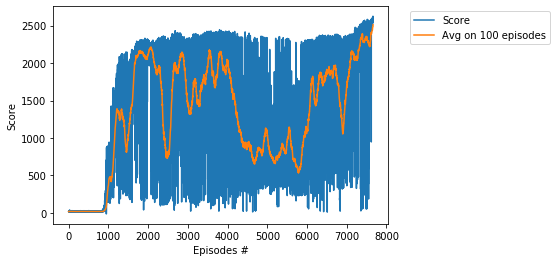

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [ ]:
play(env=env, agent=agent, num_episodes=5)

In [ ]:
env.close()

In [ ]:
env_render.close()